<a href="https://colab.research.google.com/github/KaranSharma0712/Learning-NLP/blob/main/micrograd%20updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None
    self._prev = set(_children)
    self._op = _op
    self.label = label



  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad  += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self,other):
    return self*other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out  = Value(t,(self,),'tanh')
    def _backward():
      self.grad += (1 - t**2)*out.grad
    out._backward = _backward

    return out

  def exp(self):
    x=self.data
    out = Value(math.exp(x),(self,),'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

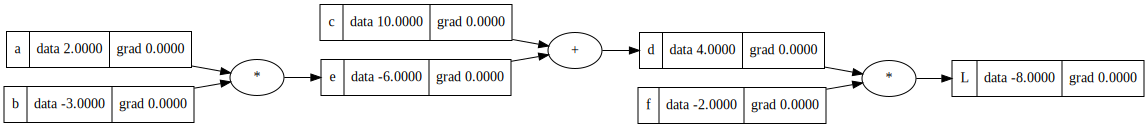

In [ ]:
draw_dot(L)

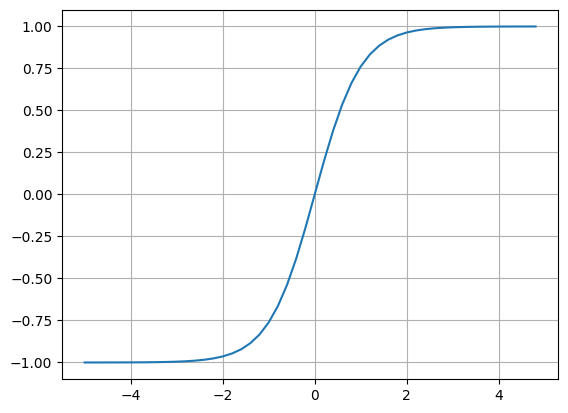

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o=n.tanh();o.label =  'o'

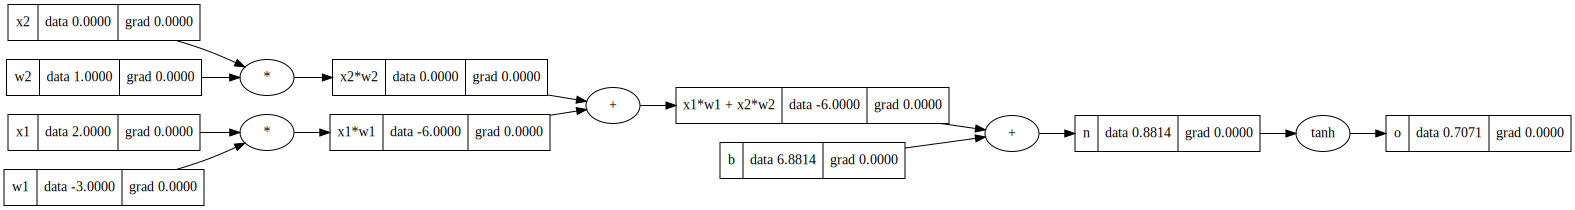

In [ ]:
draw_dot(o)

In [ ]:
o.grad = 1.0
o._backward()

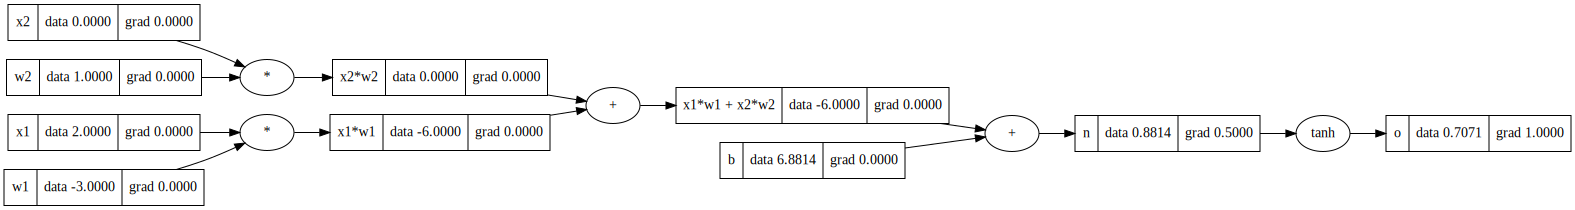

In [ ]:
draw_dot(o)

In [ ]:
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

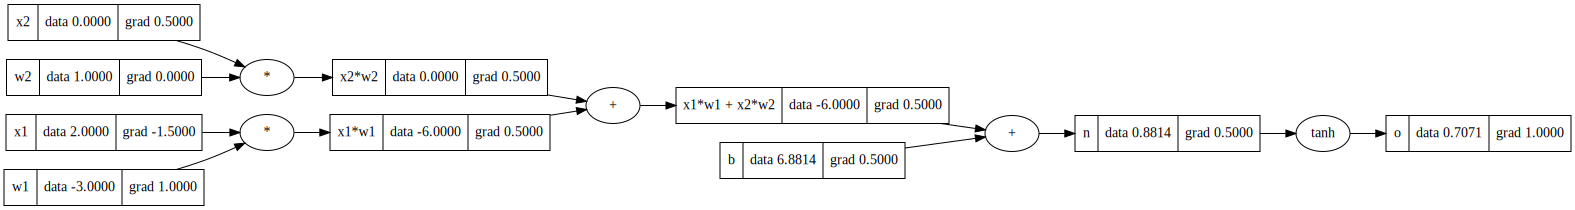

In [ ]:
draw_dot(o)

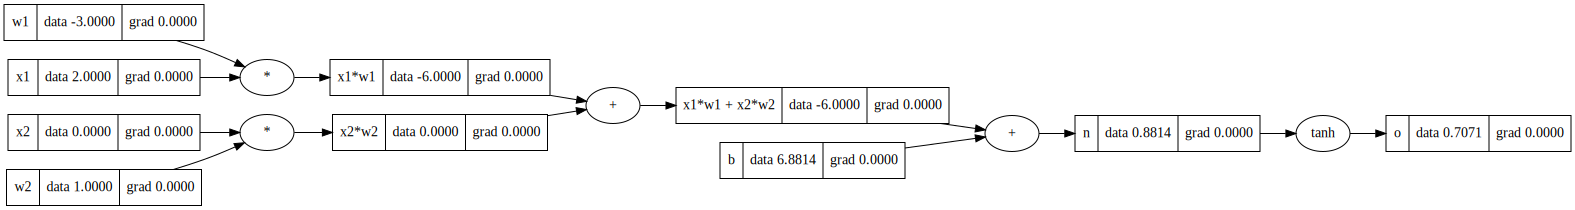

In [ ]:
draw_dot(o)

In [ ]:
o.backward()

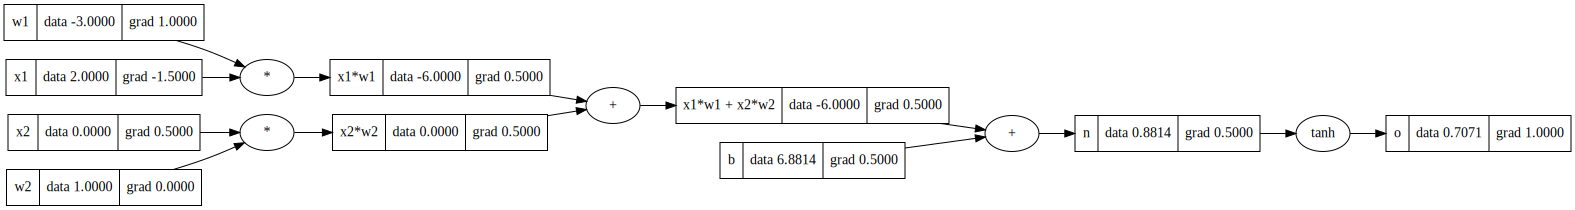

In [ ]:
draw_dot(o)

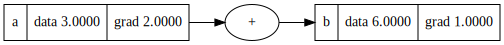

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

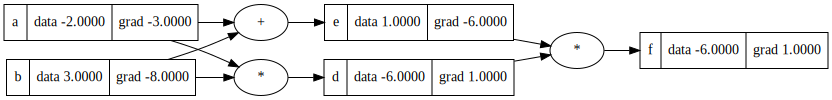

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'
f.backward()
draw_dot(f)

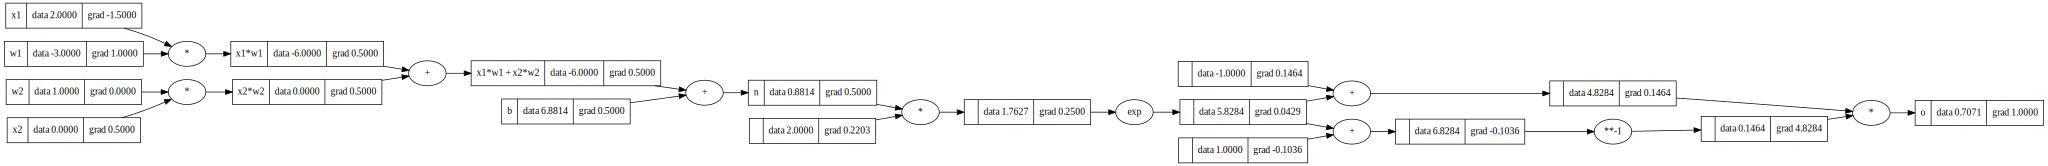

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [3]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [26]:
import random
class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
    out = act.tanh()
    return out

  def parameters(self):
      return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params
    #instead of above 5 lines, we can drectly write:
    # return [p for neuron in self.neurons for p in neuron.paramters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [27]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.5796761538157078)

In [28]:
n.parameters()

[Value(data=0.3568492443452671),
 Value(data=0.13441688389721929),
 Value(data=0.9596493280410714),
 Value(data=-0.31003857498273923),
 Value(data=-0.08738325664553681),
 Value(data=0.5519842738604841),
 Value(data=0.23521262970470258),
 Value(data=-0.19845411519832767),
 Value(data=0.32008495143159954),
 Value(data=0.4352835529724266),
 Value(data=-0.927161389017084),
 Value(data=-0.6278827900434885),
 Value(data=-0.9340026919146109),
 Value(data=-0.9322404041543209),
 Value(data=-0.21414737361034186),
 Value(data=-0.6348894672439751),
 Value(data=-0.6485485655022554),
 Value(data=-0.070193329751288),
 Value(data=-0.33678734470391203),
 Value(data=0.8170073335217669),
 Value(data=0.1395412367535489),
 Value(data=-0.668274778127858),
 Value(data=0.24953424595387852),
 Value(data=-0.47687548443984884),
 Value(data=0.01080508783105194),
 Value(data=0.2990212910428576),
 Value(data=0.8394419851911035),
 Value(data=0.0053712599652468995),
 Value(data=-0.9652144656764354),
 Value(data=0.241

In [30]:
len(n.parameters())

41

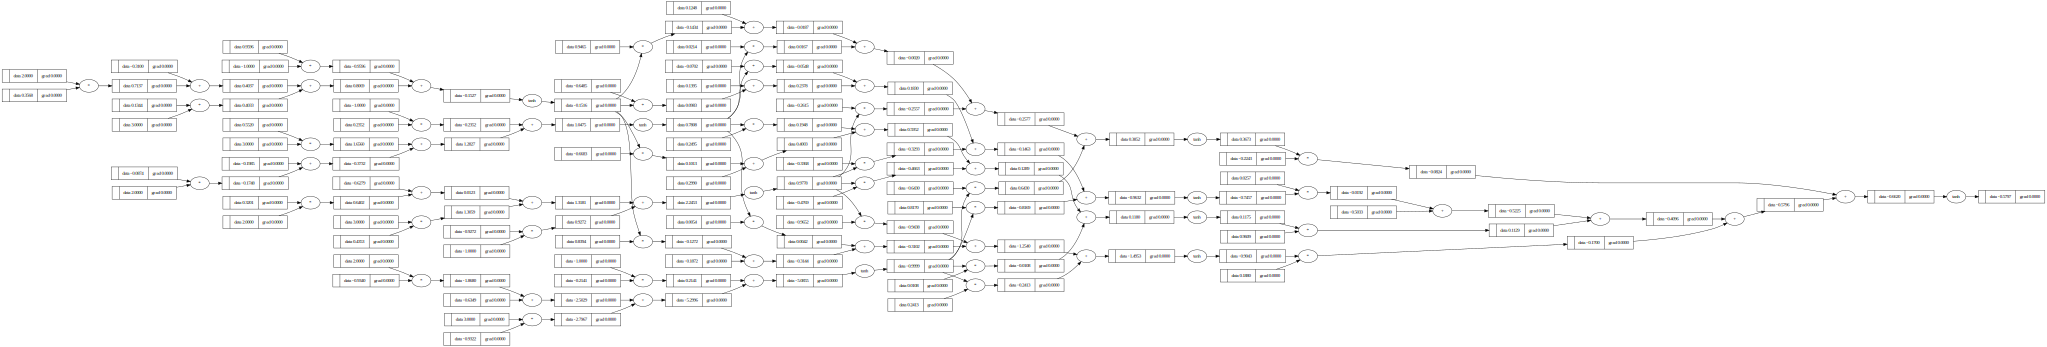

In [31]:
draw_dot(n(x))

In [32]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.5796761538157078),
 Value(data=-0.6556177102759317),
 Value(data=-0.32885851979685),
 Value(data=-0.33350799618786753)]

In [33]:
for p in n.parameters():
    p.grad = 0.0
loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=4.842650374755837)

In [58]:
loss.backward()

In [35]:
n.layers[0].neurons[0].w[0].grad

3.929131919672861

In [36]:
n.layers[0].neurons[0].w[0].data

0.3568492443452671

In [59]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [64]:
for p in n.parameters():
    p.grad = 0.0
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=0.002722395528020677)

In [61]:
ypred

[Value(data=0.9834221162251219),
 Value(data=-0.947019497234004),
 Value(data=-0.8713722695402341),
 Value(data=0.9810679562959554)]

In [62]:
n.parameters()

[Value(data=-0.01610789145156595),
 Value(data=-0.53675811396562),
 Value(data=1.5062128479725014),
 Value(data=-0.457207524114598),
 Value(data=-0.041789663935290225),
 Value(data=0.6496886318201365),
 Value(data=0.053652561968189384),
 Value(data=-0.18588469973927618),
 Value(data=0.370980418683239),
 Value(data=0.39705767167503064),
 Value(data=-0.8228702249643132),
 Value(data=-0.60282246982183),
 Value(data=-0.9312608440352397),
 Value(data=-0.9294667783637292),
 Value(data=-0.2160098191956283),
 Value(data=-0.6320285466801518),
 Value(data=-0.6468092908977229),
 Value(data=-0.06878857311729504),
 Value(data=-0.3366673759640249),
 Value(data=0.8108120136905731),
 Value(data=0.1458496406433815),
 Value(data=-1.2672526252621958),
 Value(data=0.401671110887833),
 Value(data=0.3325489283332051),
 Value(data=-0.12912839337484713),
 Value(data=0.4362896452202574),
 Value(data=0.8319303799979834),
 Value(data=0.013774199737208805),
 Value(data=-0.9549601322664012),
 Value(data=0.22638901

In [63]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 0.019985275225833127
1 0.012923195370604634
2 0.009955987644004302
3 0.008241483756114071
4 0.007104522984956561
5 0.006287529421807509
6 0.005668313671268707
7 0.00518071681458142
8 0.004785529387515437
9 0.00445792284469965
10 0.00418135512396925
11 0.003944351033929555
12 0.0037386840765299095
13 0.0035582931974341763
14 0.003398608327615262
15 0.0032561146462263386
16 0.0031280620752581825
17 0.003012266273911983
18 0.0029069690503106876
19 0.0028107383907782202
